# National Agricultural Imagery Program (NAIP): Cold Springs Fire

In [49]:
import glob
import os
import pathlib
import re

import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray as rxr

In [6]:
os.chdir(os.path.join(
    pathlib.Path.home(), 'earth-analytics', 'data', 'cold-springs'))

<AxesSubplot:>

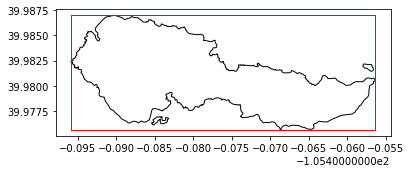

In [7]:
# Downloading fire perimeter for Cold Springs Fire
cs_perimeter_url = (
    "https://services3.arcgis.com/T4QMspbfLg3qTGWY/arcgis/rest/services/"
    "Historic_Geomac_Perimeters_Combined_2000_2018/FeatureServer/0/query"
    "?where=%20incidentname%20%3D%20'COLD%20SPRINGS'%20AND%20state%20%3D%20'CO'"
    "&outFields=*"
    "&outSR=4326"
    "&f=json")
cs_perimeter_4326_gdf = gpd.read_file(cs_perimeter_url)
cs_envelope_4326_gdf = cs_perimeter_4326_gdf.envelope

# Save envelope as file for data download
cs_envelope_dir = 'cold-springs-envelope'
if not os.path.exists(cs_envelope_dir):
    os.makedirs(cs_envelope_dir)
cs_envelope_path = os.path.join(cs_envelope_dir, 'cold-springs-envelope.shp')
cs_envelope_4326_gdf.to_file(cs_envelope_path)

# Plot perimeter and envelope to check download
ax = cs_perimeter_4326_gdf.plot(facecolor='none', edgecolor='black')
cs_envelope_4326_gdf.plot(ax=ax, facecolor='none', edgecolor='red')

In [27]:
%%bash
find ~/earth-analytics/data/cold-springs

/Users/elsa/earth-analytics/data/cold-springs
/Users/elsa/earth-analytics/data/cold-springs/cold-springs-envelope
/Users/elsa/earth-analytics/data/cold-springs/cold-springs-envelope/cold-springs-envelope.prj
/Users/elsa/earth-analytics/data/cold-springs/cold-springs-envelope/cold-springs-envelope.zip
/Users/elsa/earth-analytics/data/cold-springs/cold-springs-envelope/cold-springs-envelope.shp
/Users/elsa/earth-analytics/data/cold-springs/cold-springs-envelope/cold-springs-envelope.cpg
/Users/elsa/earth-analytics/data/cold-springs/cold-springs-envelope/cold-springs-envelope.shx
/Users/elsa/earth-analytics/data/cold-springs/cold-springs-envelope/cold-springs-envelope.dbf
/Users/elsa/earth-analytics/data/cold-springs/.DS_Store
/Users/elsa/earth-analytics/data/cold-springs/naip-manual
/Users/elsa/earth-analytics/data/cold-springs/naip-manual/.DS_Store
/Users/elsa/earth-analytics/data/cold-springs/naip-manual/m_3910505_nw_13_1_20150919
/Users/elsa/earth-analytics/data/cold-springs/naip-manu

In [55]:
# Load .tif files into xarray
tif_pattern = os.path.join('naip-manual', '*', '*.tif')
naip_files = glob.glob(tif_pattern)
date_re = re.compile(r'm_3910505_nw_13_1_(?P<date>\d+)\.tif')

naip_das = []
naip_crs = None
for naip_file in naip_files:
    # Extract date
    date = pd.to_datetime(date_re.search(naip_file).group('date'))
    # date = pd.to_datetime(naip_file[-12:-4])

    # Opening files
    single_ts_da = rxr.open_rasterio(naip_file, masked=True).squeeze()
    if naip_crs is None:
        naip_crs = single_ts_da.rio.crs
        cs_envelope_naip_gdf = cs_envelope_4326_gdf.to_crs(naip_crs)
    
    single_ts_da = single_ts_da.rio.clip(cs_envelope_naip_gdf)
    single_ts_da = single_ts_da.assign_coords(date=date)
    naip_das.append(single_ts_da)

naip_da = xr.concat(naip_das, dim='date')

<AxesSubplot:title={'center':'spatial_ref = 0, date = 2017-09-02'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

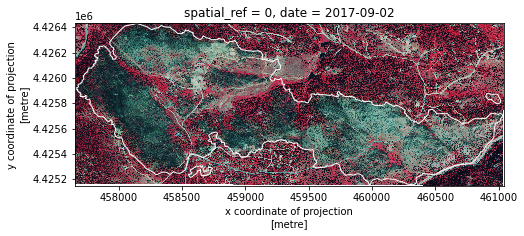

In [56]:
cs_perimeter_naip_gdf = cs_perimeter_4326_gdf.to_crs(naip_plt_2017_da.rio.crs)
fig, ax = plt.subplots(1, 1, figsize=(8, 3))

naip_plt_2017_da = naip_da.sel(date='2017', band=[4, 1, 2]).squeeze() / 255
naip_plt_2017_da.plot.imshow(ax=ax)
cs_perimeter_naip_gdf.plot(ax=ax, facecolor='none', edgecolor='white')

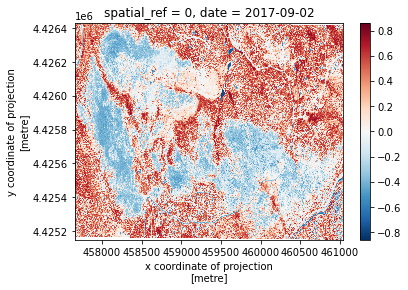

In [59]:
def norm_diff(band_1, band_2):
    return (band_1 - band_2) / (band_1 + band_2)

ndvi = norm_diff(naip_plt_2017_da.sel(band=4), naip_plt_2017_da.sel(band=1))
ndvi.plot.imshow()